In [1]:
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# Image à traiter

(321, 481)

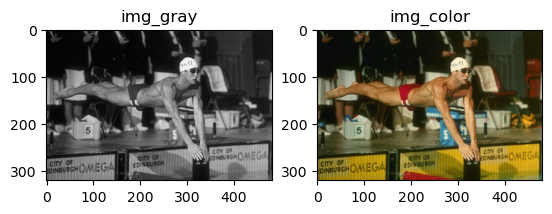

In [41]:
path='BSDS300/images/train/153093.jpg'
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(path)
n, m = img_gray.shape


plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')        
plt.title("img_gray")

plt.subplot(1, 2, 2)
plt.imshow(img_color[...,::-1])        
plt.title("img_color")
n, m

# Paramètres

In [18]:
# Paramètres
sp_in_line = 14
seuil = 0.85
k=0.5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

# Gradient

### Fonctions

In [19]:
def sobel_x(img):
    n, m=img.shape
    gradx=np.zeros((n, m))

    for i in range(1,n-1):
        for j in range(1,m-1):
            gradx[i,j] = img[i-1,j+1] + 2*img[i,j+1] + img[i+1,j+1] - img[i-1,j-1] - 2*img[i,j-1] - img[i+1,j-1]
            
    return gradx

def sobel_y(img):
    n, m=img.shape
    grady=np.zeros((n, m))

    for i in range(1,n-1):
        for j in range(1,m-1):
            grady[i,j] = img[i-1,j-1] + 2*img[i-1,j] + img[i-1,j+1] - img[i+1,j-1] - 2*img[i+1,j] - img[i+1,j+1]
        
    return grady

def sobel(img):
    gradx, grady = sobel_x(img), sobel_y(img)
    grad = np.sqrt(gradx*gradx+grady*grady)
    grad[0]=grad[1]
    grad[n-1]=grad[n-2]
    grad[:,0]=grad[:,1]
    grad[:,m-1]=grad[:,m-2]
    return grad

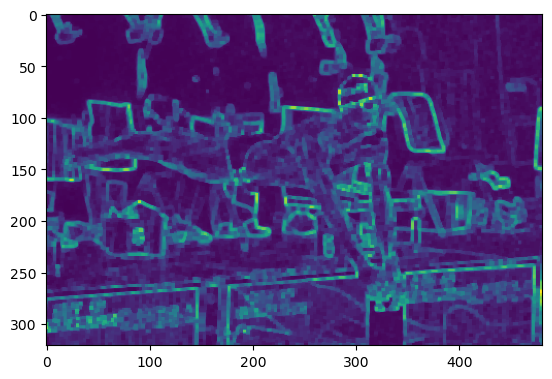

In [20]:
# Image 
#filt_img = cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, kernel)
#filt_img = cv2.morphologyEx(filt_img, cv2.MORPH_CLOSE, kernel)

# Gradient
grad=sobel(img_gray)
grad = grad*(255/np.max(grad))

filt_grad = cv2.morphologyEx(grad, cv2.MORPH_OPEN, kernel)
filt_grad = cv2.morphologyEx(filt_grad, cv2.MORPH_CLOSE, kernel)

#filt_grad = ndi.gaussian_filter(grad, 3)
plt.imshow(filt_grad)

# Cellules et minimas du gradient

### Réseau initial

In [21]:
# sigma: pas du réseau
# sp_in_line: nombre de superpixels par ligne 

def cell_centers(img, sigma=5, sp_in_line=None, grid="hexa"):
    n, m = img.shape
    img_centers = np.zeros((n,m))
    centers_coordinates = []
    
    if grid=="square":
        
        if sp_in_line:
            sigma = int(np.round(m/sp_in_line))
            
        for i in range(sigma//2,n,sigma):
            for j in range(sigma//2,m,sigma):
                img_centers[i,j]=255
                centers_coordinates.append((i,j))
                    
    if grid=="hexa":
        
        if sp_in_line:
            sigma=np.round(m/(3/2*sp_in_line))
            
        else:
            sp_in_line = np.round(m/(3/2*sigma))
            
        step_l, step_c = int(np.round((np.sqrt(3)/2)*sigma)), int(np.round((3/2)*sigma))
        
        d_c=m-(sp_in_line-1)*step_c
        offset_c=int(np.round(d_c/2))
        
        for i in range(0,n,2*step_l):
            for j in range(offset_c,m,2*step_c):
                img_centers[i,j]=255
                centers_coordinates.append((i,j))
                
        for i in range(step_l,n,2*step_l):
            for j in range(offset_c+step_c,m,2*step_c):
                img_centers[i,j]=255
                centers_coordinates.append((i,j))

    return img_centers, centers_coordinates, sigma

### Carte de distance

In [22]:
# Carte de distance
def carte_distance(img_bin, 
                   masque_avant=[(-2,-1,11),(-2,1,11),(-1,-2,11),(-1,-1,7),(-1,0,5),(-1,1,7),(-1,2,11),(0,-1,5),(0,0,0)],
                   masque_arriere=[(0,0,0),(0,1,5),(1,-2,11),(1,-1,7),(1,0,5),(1,1,7),(1,2,11),(2,-1,11),(2,1,11)]
                  ):
    
    carte = np.copy(img_bin)
    for i in range(n):
        for j in range(m):
            if img_bin[i, j]==0:
                carte[i, j]=np.inf
        
    for l in range(n):
        for c in range(m):
            C=[]
            for a in masque_avant:
                i, j, v = a
                if l+i<n and c+j<m and l+i>=0 and c+j>=0:
                    C.append(carte[l+i, c+j]+v)      
            carte[l, c] = min(C)

    for l in range(n-1,-1,-1):
        for c in range(m-1,-1,-1):
            C=[]
            for a in masque_arriere:
                i, j, v = a
                if l+i<n and c+j<m and l+i>=0 and c+j>=0:
                    C.append(carte[l+i, c+j]+v)
            carte[l, c] = min(C)
    
    return carte


def seuillage(carte, p):
    m = np.max(carte[:50, :50])
    seuil = p*m
    carte_seuil = np.zeros_like(carte)
    n, m = carte.shape
    for i in range(n):
        for j in range(m):
            if carte[i, j] < seuil:
                carte_seuil[i, j]=1
            else:
                carte_seuil[i, j]=0
    return carte_seuil

### Composantes connexes

In [23]:
# Etiquetage en composantes connexes
def searchTagsInPast(Map, i, j, con_type='8'):
    # con_type = '8' or '4' (4 connected or 8 connected)
    tags = []
    
    if i-1>=0 and Map[j][i-1] > 0:
        if Map[j][i-1] not in tags:
            tags.append(Map[j][i-1])
            
    if j-1>=0 and Map[j-1][i] > 0:
        if Map[j-1][i] not in tags:
            tags.append(Map[j-1][i])
        
    if con_type=='8':
        if i-1>=0 and j-1>=0 and Map[j-1][i-1] > 0:
            if Map[j-1][i-1] not in tags:
                tags.append(Map[j-1][i-1])
        if i+1<Map.shape[1] and j-1>=0 and Map[j-1][i+1] > 0:
            if Map[j-1][i+1] not in tags:
                tags.append(Map[j-1][i+1])
    return tags

def tagging(im, con_type='8'):
    # tags are integers starting at 1
    connected_components=[]
    newtag = 0
    tagmap = np.zeros((im.shape[0], im.shape[1]), dtype=np.int8)

    for j in range(im.shape[0]):
        for i in range(im.shape[1]):
            if im[j][i] > 0 :
                # Look in the past (pixels up and left)
                pasttags = searchTagsInPast(tagmap, i, j, con_type)
                
                # Aucun pixel déjà traité dans la zone de connexité
                if len(pasttags) == 0:
                    newtag += 1
                    tagmap[j][i] = newtag                    
                    connected_components.append([(j,i)])
                    
                # Un seul pixel déjà traité dans la zone de connexité
                elif len(pasttags) == 1:
                    tag=pasttags[0]
                    tagmap[j][i] = tag
                    connected_components[tag-1].append((j,i))

                # Plusieurs pixels déjà traités dans la zone de connexité
                elif len(pasttags) > 1:
                    tag=min(pasttags)
                    tagmap[j][i] = tag
                    connected_components[tag-1].append((j,i))
                    
                    # On garde l'étiquette la plus faible dans la zone
                    k = pasttags.index(min(pasttags))
                    pasttags.pop(k)
                    
                    # On regroupe toutes les composantes connexes liées par le pixel traité
                    for t in pasttags:
                        connected_components[tag-1]+=connected_components[t-1]
                        connected_components[t-1]=[]
                        
                    # On supprime les composantes connexes devenus obsolètes    
                    connected_components = rebuild_cc(connected_components)
                    # On applique ces changements à la tagmap
                    tagmap = rebuild_tagmap(connected_components, im)
                    newtag=np.max(tagmap)
                    
    return tagmap, connected_components
                
def rebuild_cc(connected_components):
    new_connected_components = []
    for cc in connected_components:
        if cc!=[]:
            new_connected_components.append(cc)
    return new_connected_components

def rebuild_tagmap(connected_components, im):
    tagmap = np.zeros((im.shape[0], im.shape[1]), dtype=np.int8)
    for k in range(len(connected_components)):
        for point in connected_components[k]:
            j,i=point
            tagmap[j,i]=k+1
            
    return tagmap

### Markers

In [24]:
# Markers de l'image
# Renvoit une liste de listes d'indices des markers par cellule
def get_markers(cellules, grad):
    markers=[]
    for cell in cellules:
        min_grad = np.inf
        markers_in_cell=[]
        
        #Minimum du gradient dans la cellule
        for k in range(len(cell)):
            i, j = cell[k]
            if grad[i, j]<=min_grad:
                min_grad=grad[i, j]
                
        #Markers: pixels à la valeur du minimum
        for k in range(len(cell)):
            i, j = cell[k]
            if grad[i, j]==min_grad:
                markers_in_cell.append((i, j))
        markers.append(markers_in_cell)
        
    return markers

# Renvoit une image avec les markers en blancs
def img_with_markers(markers_in_cell, img_shape):
    n, m = img_shape
    img=np.zeros((n, m), dtype=np.int8)
    for k in range(len(markers_in_cell)):
        i, j = markers_in_cell[k]
        img[i, j]=1
    return img

def cc_of_max_len(ccs):
    m_l=len(ccs[0])
    index=0
    for k in range(1, len(ccs)):
        if len(ccs[k])>m_l:
            m_l=len(ccs[k])
            index=k

    return index

# On garde, pour chaque cellule, la composante connectée la plus grande parmi les markers
# Marker = pixel correspond à un minimum du gradient dans la cellule
def get_connected_markers(markers, img_shape):
    connected_markers=[]
    
    # Pour chaque cellule
    for markers_in_cell in markers:
        
        # Si il y a plus d'un marker dans la cellule
        if len(markers_in_cell)>1:
            
            # On cherche les composantes connectées dans une image la plus petite possible contenant tous les markers
            lmin, lmax, cmin, cmax = get_boundaries(markers_in_cell)
            img_bin=img_with_markers(markers_in_cell, img_shape)[lmin:lmax+1, cmin:cmax+1]
            tagmap, connected_components = tagging(img_bin)
            connected_components = translate_ccs(connected_components, lmin, cmin)

            # On garde uniquement la composante de taille maximale
            connected_marker = connected_components[cc_of_max_len(connected_components)]
            connected_markers.append(connected_marker)
            
        # Sinon, on garde juste le pixel unique
        else:
            connected_markers.append(markers_in_cell)
                    
    return connected_markers

def img_from_markers(markers, img_shape):
    n, m=img_shape
    img_markers = np.zeros((n, m))
    for cell_markers in markers:
        for k in range(len(cell_markers)):
            i, j  = cell_markers[k]
            img_markers[i, j]=1
    return img_markers

def get_boundaries(markers_in_cell):
    (lmin, lmax), (cmin, cmax) = markers_in_cell[0], markers_in_cell[0]
    for k in range(1,len(markers_in_cell)):
        i,j=markers_in_cell[k]
        if i<lmin:
            lmin=i
        if i>lmax:
            lmax=i
        if j<cmin:
            cmin=j
        if j>cmax:
            cmax=j
    return lmin, lmax, cmin, cmax

def translate_ccs(connected_components, lmin, cmin):
    translated_ccs = []
    for cc in connected_components:
        
        translated_cc = []
        for k in range(len(cc)):
            (i,j) = cc[k]
            translated_cc.append((i+lmin, j+cmin))
        
        translated_ccs.append(translated_cc)
        
    return translated_ccs
    

In [25]:
def plot_images(carte_dist_cells, carte_cells_seuil, img_markers, img_connected_markers):
    plt.figure(figsize=(10,7))
    
    plt.subplot(2, 2, 1)
    plt.imshow(carte_dist_cells, cmap='gray')        
    plt.title("Grid")

    plt.subplot(2, 2, 2)
    plt.imshow(carte_cells_seuil, cmap='gray')        
    plt.title("Cellules")
    
    plt.subplot(2, 2, 3)
    plt.imshow(img_markers)        
    plt.title("Minimas du gradient")
    
    plt.subplot(2, 2, 4)
    plt.imshow(img_connected_markers)        
    plt.title("Markers")
    
    plt.tight_layout()

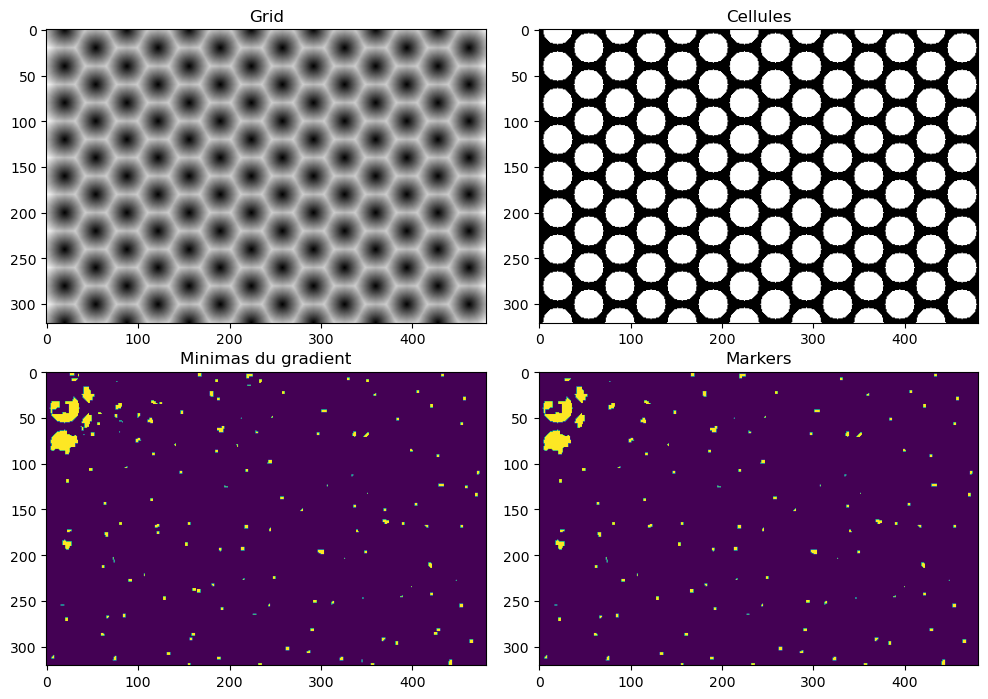

In [26]:
# Grid
img_centers, centers_coordinates,sigma = cell_centers(img_gray, sp_in_line=sp_in_line, grid='hexa')
carte_dist_cells=carte_distance(img_centers)

# Cellules
carte_cells_seuil = seuillage(carte_dist_cells, seuil)

# Minimas du gradient
_, cells = tagging(carte_cells_seuil)
markers = get_markers(cells, filt_grad)
img_markers = img_from_markers(markers, (n, m))

# Markers
connected_markers = get_connected_markers(markers, (n, m))
img_connected_markers = img_from_markers(connected_markers, (n, m))

plot_images(carte_dist_cells, carte_cells_seuil, img_markers, img_connected_markers)

# Combinaison gradient et carte de distance des markers

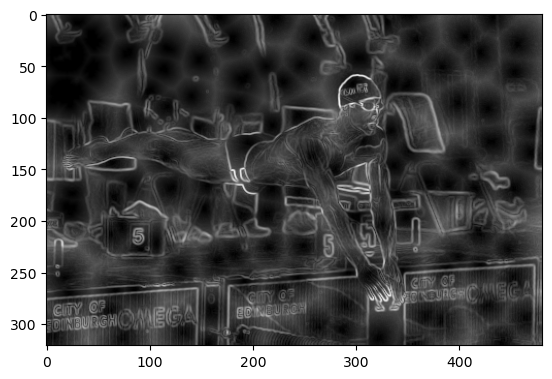

In [79]:
# Spatially regularised gradient
carte_dist_markers = carte_distance(img_connected_markers)
carte_dist_markers = carte_dist_markers*(255/np.max(carte_dist_markers))

reg_grad = carte_dist_markers*k + grad

plt.imshow(reg_grad, cmap='gray')

# Watershed et résultat

In [80]:
def get_watershed_markers(markers, img_shape):
    n, m=img_shape
    img_markers = np.zeros((n, m))
    v=1
    for cell_markers in markers:
        for k in range(len(cell_markers)):
            i, j  = cell_markers[k]
            img_markers[i, j]=v
        v+=1
    return img_markers

def get_watershed_borders(labels):
    watershed_borders = np.zeros_like(labels)
    n, m = watershed_borders.shape
    for i in range(n):
        for j in range(m):
            if labels[i,j]==0:
                watershed_borders[i,j]=255
    return watershed_borders

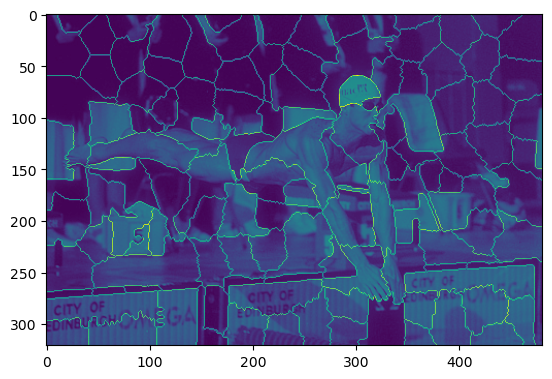

In [81]:
watershed_markers = get_watershed_markers(connected_markers, (n,m))
labels = watershed(reg_grad, watershed_markers, watershed_line=True)
watershed_borders = get_watershed_borders(labels)
plt.imshow(watershed_borders+img_gray)

In [118]:
def color_result(labels, img_color, c=[255, 255, 255]):
    n, m, _ = img_color.shape
    res = img_color.copy()
    for i in range(n):
        for j in range(m):
            if labels[i,j]==0:
                res[i,j]=c
    return res

def grad_markers(carte_dist_markers, k, grad, img_connected_markers):
    n, m = img_connected_markers.shape
    res = np.zeros((n,m,3))
    if np.max(carte_dist_markers*k)>255:
        res[:,:,0] = (carte_dist_markers*k)*(255/np.max(carte_dist_markers*k))
        res[:,:,1] = grad*(255/np.max(carte_dist_markers*k))
        res[:,:,2] = img_connected_markers*(255/np.max(img_connected_markers))
    else:
        res[:,:,0] = carte_dist_markers*k
        res[:,:,1] = grad
        res[:,:,2] = img_connected_markers*(255/np.max(img_connected_markers))
    return res.astype(np.int64)

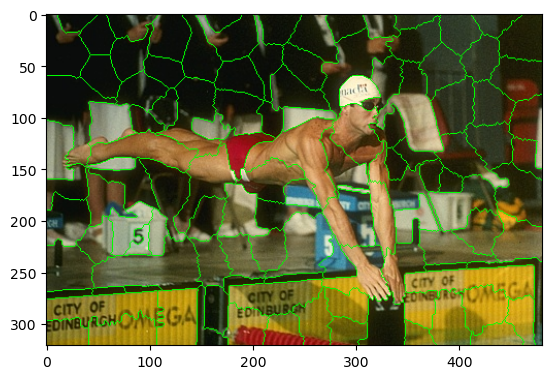

In [53]:
res = color_result(labels, img_color, c=[0,255,0])
plt.imshow(res[...,::-1])

# Tests

In [104]:
def main(img_gray, sp_in_line, seuil, k, filt_param, grid='hexa', img_color=None):
    grad=sobel(img_gray)
    grad = grad*(255/np.max(grad))
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(filt_param,filt_param))
    filt_grad = cv2.morphologyEx(grad, cv2.MORPH_OPEN, kernel)
    filt_grad = cv2.morphologyEx(filt_grad, cv2.MORPH_CLOSE, kernel)
    
    # Grid
    img_centers, centers_coordinates,sigma = cell_centers(img_gray, sp_in_line=sp_in_line, grid='hexa')
    carte_dist_cells=carte_distance(img_centers)

    # Cellules
    carte_cells_seuil = seuillage(carte_dist_cells, seuil)

    # Minimas du gradient
    _, cells = tagging(carte_cells_seuil)
    markers = get_markers(cells, filt_grad)
    img_markers = img_from_markers(markers, (n, m))

    # Markers
    connected_markers = get_connected_markers(markers, (n, m))
    img_connected_markers = img_from_markers(connected_markers, (n, m))
    
    carte_dist_markers = carte_distance(img_connected_markers)
    carte_dist_markers = carte_dist_markers*(255/np.max(carte_dist_markers))

    reg_grad = carte_dist_markers*k + grad
    
    watershed_markers = get_watershed_markers(connected_markers, (n,m))
    labels = watershed(reg_grad, watershed_markers, watershed_line=True)
    
    plt.figure(figsize=(15,15))
    if img_color is not None:
        res = color_result(labels, img_color, c=[0,255,0])
        plt.subplot(1,2,1)
        plt.imshow(res[...,::-1])
        plt.title("Result")
    else:
        watershed_borders = get_watershed_borders(labels)
        plt.imshow(watershed_borders+img_gray*(255/np.max(img_gray)))
        plt.title("Result")
        
    plt.subplot(1,2,2)
    view_grad = grad_markers(carte_dist_markers, k, grad, img_connected_markers)
    plt.imshow(view_grad)
    plt.title("Regularised gradient and markers")
    

(321, 481)

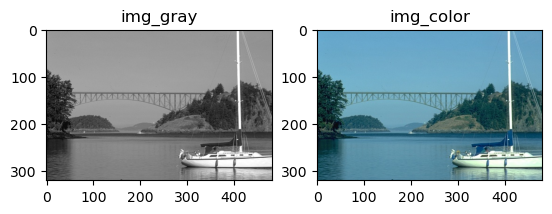

In [107]:
img_path = 'BSDS300/images/train/22090.jpg'

img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(img_path)
n, m = img_gray.shape


plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')        
plt.title("img_gray")

plt.subplot(1, 2, 2)
plt.imshow(img_color[...,::-1])        
plt.title("img_color")
n, m

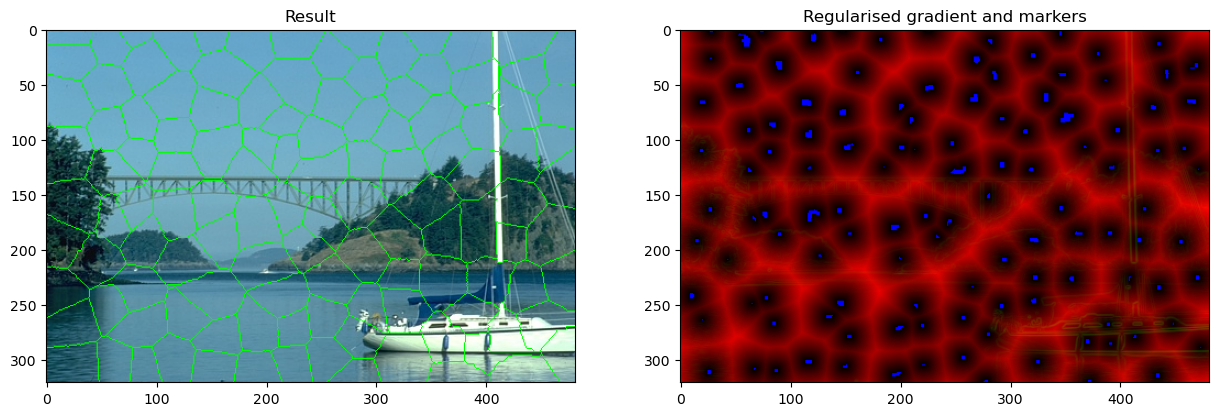

In [119]:
sp_in_line = 14
#sigma = 25
seuil = 0.85
k=5              #Régularisation
a=3              #Paramètre du filtre du gradient

main(img_gray, sp_in_line, seuil, k, a, grid='hexa', img_color=img_color)

# Évaluation des résultats

### Contour Density

In [18]:
def count_borders(labels):
    count=0
    n, m = labels.shape
    for i in range(n):
        for j in range(m):
            if labels[i,j]==0:
                count+=1
    return count

def Contour_Density(labels):
    n, m = labels.shape
    Sc = count_borders(labels)
    Sb = 2*n+2*(m-2)
    N = n*m
    CD = (Sc+Sb)/N
    return CD

In [19]:
Contour_Density(labels)

0.059883031845648665

### Similarity

In [20]:
def superpixels_as_sets(labels):
    sp_sets = [[] for k in range(np.max(labels))]
    n, m = labels.shape
    for i in range(n):
        for j in range(m):
            if labels[i,j]>0:
                sp_sets[labels[i,j]-1].append((i,j))
    return sp_sets

def mismatch_factor(a, b):
    return 1-(len(inter(a, b))/len(union(a, b)))

def union(a, b):
    union_set = b
    for p in range(len(a)):
        c = a[p]
        if c not in b:
            union_set.append(c)
    return union_set
                
def inter(a, b):
    inter_set = []
    for p in range(len(a)):
        c = a[p]
        if c in b:
            inter_set.append(c)
    return inter_set

def centered_sp(s, n, m):
    s_as_array = np.array(s)
    center = np.average(s, axis=0)
    sp_star = []
    for k in range(len(s)):
        i,j=s[k]
        sp_star.append((int(np.round(i-center[0]+n//2)), int(np.round(j-center[1]+m//2))))
    return sp_star

def avg_centered_shape(sp_sets,n,m):
    centered_sp_sets = [centered_sp(s,n,m) for s in sp_sets]
    
    A = np.zeros((n,m))
    for s in centered_sp_sets:
        for k in range(len(s)):
            i,j = s[k]
            A[i,j]+=1
            
    avg_area = np.average([len(s) for s in centered_sp_sets])
    
    t = np.max(A)
    avg_ctrd_shape = thresh(A,t)
    
    while len(avg_ctrd_shape)<avg_area:
        t-=1
        avg_ctrd_shape = thresh(A,t)
    
    return avg_ctrd_shape

def thresh(A, t):
    T = []
    n, m = A.shape
    for i in range(n):
        for j in range(m):
            if A[i,j]>=t:
                T.append((i,j))
    return T
                
    

def avg_mismatch_factor(labels):
    n, m = labels.shape
    MF = 0
    sp_sets = superpixels_as_sets(labels)
    N = len(sp_sets)
    avg_ctrd_shape = avg_centered_shape(sp_sets,n,m)
    
    for k in range(N):
        MF += (1/N)*mismatch_factor(centered_sp(sp_sets[k], n, m), avg_ctrd_shape)
        
    return MF
    

In [21]:
avg_mismatch_factor(labels)

0.6732494182139003

### Boundary Recall

In [33]:
#Voir ici pour les images de segmentation: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images.html
path_gt = "176035.jpg"
ground_truth = cv2.imread(path_gt, cv2.IMREAD_GRAYSCALE)

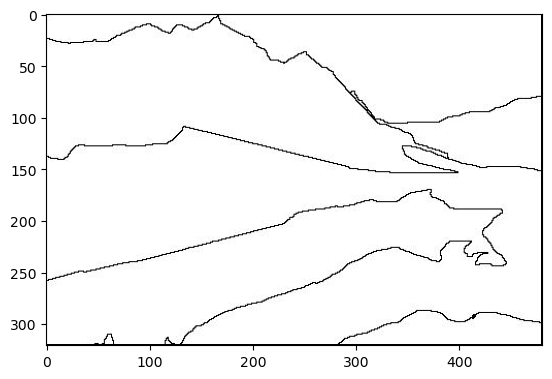

In [37]:
plt.imshow(ground_truth, cmap='gray')

In [55]:
def get_boundaries(labels):
    boundaries = []
    n, m = labels.shape
    for i in range(n):
        for j in range(m):
            if labels[i,j]==0:
                boundaries.append((i,j))
    return boundaries

def gt_as_pixels(ground_truth):
    gt_pixels = []
    n, m = ground_truth.shape
    for i in range(n):
        for j in range(m):
            if ground_truth[i, j]==0:
                gt_pixels.append((i, j))
    return gt_pixels

def l1(a, b):
    i,j=a
    p,q=b
    return abs(i-p) + abs(j-q)

def distance_to_boudaries(p, boundaries):
    d=np.inf
    for b in boundaries:
        if l1(p,b)<d:
            d=l1(p,b)
        if d<3:
            return d
    return d
            
def boundary_recall(ground_truth, labels):
    boundaries = get_boundaries(labels)
    gt_pixels = gt_as_pixels(ground_truth)
    BR=0
    for p in gt_pixels:
        if distance_to_boudaries(p, boundaries)<3:
            BR+=1
    return BR/len(gt_pixels)
    

In [56]:
boundary_recall(ground_truth, labels)

0.38803418803418804